In [1]:
import numpy as np
rng = np.random.default_rng(seed = 37)

import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torchvision as tv
from torchvision.transforms import v2
import torch.nn.functional as F

import copy

from tqdm import tqdm

# import sys
# sys.path.append('utils')

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [2]:
ENV2 = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
ENV2.eval();
for param in ENV2.parameters():
    param.requires_grad = False
inference_transform = tv.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
inference_transforms = v2.Compose([
    lambda x: x.convert('RGB'),
    inference_transform,
])
visualization_transforms = v2.Compose(
    [v2.ToImage(),
     v2.ToDtype(t.float32, scale=True),
     v2.Resize(256),
     v2.CenterCrop(224),
     ])

toImage = v2.ToPILImage()

In [3]:
fav_pic_index = 28621
data_root = 'imagenet'
imagenet_val_visual = tv.datasets.ImageNet(data_root, split = 'val', transform = visualization_transforms)
imagenet_val_inference = tv.datasets.ImageNet(data_root, split = 'val', transform = inference_transforms)
fav_image = imagenet_val_visual[fav_pic_index][0]
fav_image_inf = imagenet_val_inference[fav_pic_index][0].unsqueeze(0)

In [4]:
t.linalg.cond(fav_image)

tensor([4444069.5000, 2139346.2500,  623624.6875])

In [34]:
def blur_image_svd(image, k):
    # Compute SVD
    U, S, Vh = t.linalg.svd(image)
    S_trunc = S.detach().clone()
    # Truncate singular values
    #S_trunc[:, :k] = 0
    S_trunc[:, k + 1:] = 0
    
    # Reconstruct the image
    blurred = t.einsum('cik, ck, ckj -> cij',U, S_trunc, Vh)
    
    return blurred, S

In [37]:
blurred_image, S = blur_image_svd(fav_image, 10)

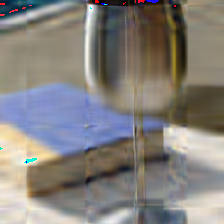

In [38]:
toImage(blurred_image)

In [98]:
ref = ENV2(fav_image_inf.to(device))
test = ENV2(blurred_image.unsqueeze(0).to(device))

In [99]:
t.nn.CosineSimilarity()(ref, test)

tensor([1.0000], device='cuda:0')

In [100]:
blurred_image, S = blur_image_svd(fav_image, 168)

In [115]:
from utils.diffeo_container import sparse_diffeo_container

diffeo = sparse_diffeo_container(224, 224)
diffeo.sparse_AB_append(4, 4, 2, 0.5, 1)
diffeo.get_all_grid()
diffeo.to(device)
inverse = diffeo.get_inverse_grid(base_learning_rate=200)

distorted = diffeo(blurred_image.unsqueeze(0).to(device))

  0%|          | 0/10000 [00:00<?, ?it/s]

 52%|█████▏    | 5159/10000 [00:02<00:02, 1855.73it/s]


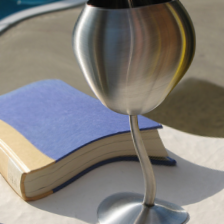

In [116]:
toImage(distorted.squeeze())

In [123]:
inverse(blurred_image_distorted.squeeze().unsqueeze(0)).shape

torch.Size([1, 1, 3, 224, 224])

In [126]:
blurred_image_distorted, S_distort = blur_image_svd(distorted.squeeze(), 168)
blurred_image_inverse, S_inv = blur_image_svd(inverse(blurred_image_distorted.squeeze().unsqueeze(0)).squeeze(), 168)

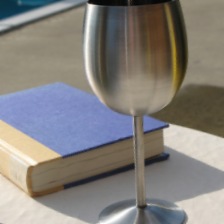

In [128]:
toImage(blurred_image_inverse)

In [133]:
S.shape

torch.Size([3, 224])

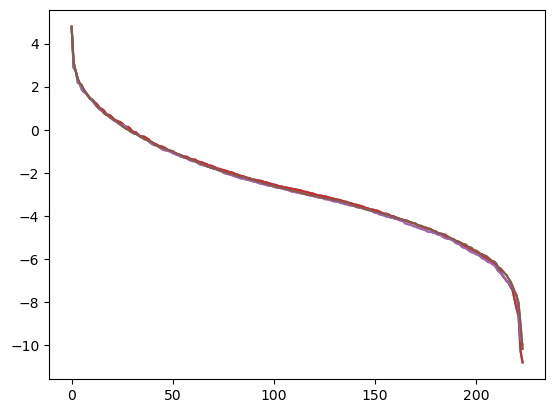

In [137]:
plt.plot(np.log(t.cat([S, S_inv]).detach().cpu().numpy().T))

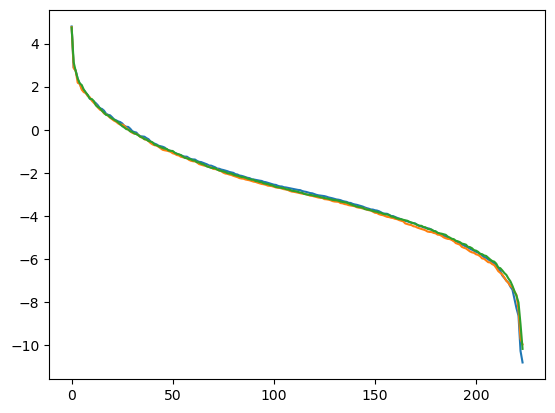

In [132]:
plt.plot(np.log(S_inv.detach().cpu().numpy().T))